In [1]:
# Load package
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import pymc as pm;import arviz as az; 
import math; import pandas as pd
from scipy.optimize import minimize
from scipy import special
import pytensor.tensor as pt
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def generate_Corr_identity(p):

    Sigma = np.zeros((p-1, p-1))
    np.fill_diagonal(Sigma, 1)
    return Sigma

def generate_data(n, p, sigma_sqr, beta, nu, corr):

    beta = beta.reshape((p, 1))
    x_i = np.random.normal(0, 1, (n, p - 1))
    x_i_correlated = x_i @ corr
    ones = np.ones((n, 1))
    x_i_full =  np.concatenate((ones, x_i_correlated), axis=1)
    XB = x_i_full @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y, x_i_full

def negative_log_likelihood_optimize_beta_sigma(params, nu):

    betas, sigma = params[:-1], params[-1]
    if sigma <= 0:
        return np.inf  # Return infinity if sigma is non-positive
    p = X.shape[1]
    B = np.reshape(betas, (p, 1))
    XB = X @ B
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    # loglikelihood
    equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -equation

def optimize_over_beta_sigma(nu):
    
    p = X.shape[1]
    bounds = [(None, None)] * p +[(0, np.inf)]
    initial_guess = np.random.normal(0, 1, size = (p+1))
    initial_guess[p] = np.abs(initial_guess[p])
    result = minimize(negative_log_likelihood_optimize_beta_sigma, initial_guess, args=(nu,), method='Nelder-Mead',bounds= bounds, options={'return_all':True})
    return [result.x,result.success,result.nit,result.allvecs]

def profile_loglikelihood(nu):
    
    optimizer = optimize_over_beta_sigma(nu)
    if optimizer[1]== True:
        sigma = optimizer[0][-1]
        beta = optimizer[0][0:-1]
        p = X.shape[1]
        B = np.reshape(beta, (p, 1))
        XB = X @ B
        n = X.shape[0]
        XB = XB.reshape((n, 1))
        eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
        return -eqt
    else:
        return np.inf 

def Hess_beta_sigma(beta, sigma, nu, X, y):

    p = X.shape[1]
    n = X.shape[0]
    beta = np.array(beta)
    sigma = np.array(sigma)
    total_b2 = 0
    total_b_sigma = 0
    total_sigma_b = 0
    total_s2 = 0
    for i in range(n):
        Xi = np.reshape(X[i,:], (p, 1))
        residual = y[i] - X[i, :] @ beta
        nu_sigma_sqr_plus_residual =  nu*(sigma**2)+ residual**2
        total_b2 = total_b2 + (- (nu_sigma_sqr_plus_residual)* np.outer(X[i,:],X[i, :]) + np.outer(X[i, :], X[i, :])*2*(residual**2))/(nu_sigma_sqr_plus_residual**2)
        #total_b_sigma = total_b_sigma + (- nu_sigma_sqr_plus_residual*2 * residual * X[i,:] + 2*(residual**3 )*X[i,:]) / (nu_sigma_sqr_plus_residual**2)
        total_sigma_b = total_sigma_b + (-2*nu*sigma*X[i,:]*residual)/(nu_sigma_sqr_plus_residual**2)
        total_s2 = total_s2 - 3 * (residual ** 2) / nu_sigma_sqr_plus_residual + ((residual ** 4) * 2 ) / (nu_sigma_sqr_plus_residual ** 2) 
    db2 = total_b2 * (nu+1)
    #dbs = total_b_sigma * (nu+1)/sigma
    dsb = total_sigma_b * (nu+1)
    dbs = dsb
    ds2 = n / (sigma ** 2) + (nu + 1) * total_s2/(sigma**2)

    hessian = np.zeros((p + 1, p + 1))
    hessian[:p, :p] = db2
    hessian[:p, p] = dbs
    hessian[p, :p] = dsb
    hessian[p, p] = ds2

    return hessian

def obs_block_det(beta, sigma, nu, X, y):
    
    block = np.array(Hess_beta_sigma(beta, sigma, nu, X, y))* -1  
    return np.linalg.det(block)

def adj_profile_loglikelihood(nu):
        
    optimizer = optimize_over_beta_sigma(nu)
    if optimizer[1]== True:
        sigma = optimizer[0][-1]
        beta = optimizer[0][0:-1]
        p = X.shape[1]
        B = np.reshape(beta, (p, 1))
        XB = X @ B
        n = X.shape[0]
        XB = XB.reshape((n, 1))
        det = obs_block_det(beta, sigma, nu, X, y)
        adj_eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))-0.5*np.log(abs(det)) 
        return -adj_eqt
    else:
        return np.inf 

def calculate_y_axix(nu_origin, nu_est):
    n = len(nu_est)
    if n == 0:
        return -1
    else:
        nu_origin_vec = nu_origin * np.ones((n, 1))
        mse = np.sum((nu_est - nu_origin_vec)**2) / n
        result = np.sqrt(mse)/nu_origin
        return result

# Task 1: 3d plot for log likelihood vs betas

In [4]:
# Generate Data
p = 2 #number of betas
beta = np.array([2, 1])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

In [5]:
def log_likelihood_betas(betas, sigma, nu):
    
    p = X.shape[1]
    B = np.reshape(betas, (p, 1))
    XB = X @ B
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    
    # loglikelihood
    equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return equation

In [6]:
b_0 = []
b_1 = []
log_likelihood = []

for intercept in np.linspace(-30,30,100):
    for slope in np.linspace(-30,30,100):
        b_0.append(intercept)
        b_1.append(slope)
        betas = [intercept, slope]
        log_likelihood.append(log_likelihood_betas(betas, sigma_sqr, nu_origin))

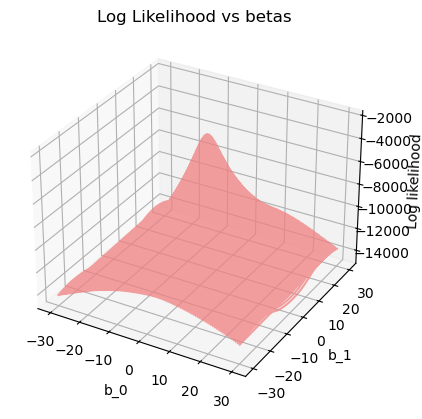

In [7]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = log_likelihood
x = b_0
y = b_1
 
# plotting
ax.plot3D(x, y, z, 'lightcoral', alpha = 0.75)
ax.set_title('Log Likelihood vs betas')
ax.set_xlabel('b_0')
ax.set_ylabel('b_1')
ax.set_zlabel('Log likelihood')
plt.show()

# Task 2: MSE plot

In [ ]:
# Jeffrey's prior
def logJeff(x):
    return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

def negative_log_profile_joint(nu):
    return -logJeff(nu) + profile_loglikelihood(nu)

def negative_log_adj_joint(nu):
    return -logJeff(nu) + adj_profile_loglikelihood(nu)

def fix_x_generate_data(n, p, sigma_sqr, beta, nu, corr,X):

    beta = beta.reshape((p, 1))
    XB = X @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y

options = {
    'maxiter': 500,  # Maximum number of iterations
    'xatol': 1e-8,
    'fatol': 1e-8
}

In [ ]:
# Fix number of observations
n = 100

result_value_mse_profile = []
result_value_mse_adj_profile =[] 
result_value_mse_profile_joint =[]
nu_list = []

p = 5
beta = np.array([2, 1, 0.3, 0.9, 1])
sigma_sqr = 1.5
corr = generate_Corr_identity(p)

x_i = np.random.normal(0, 1, (n, p - 1))
x_i_correlated = x_i @ corr
ones = np.ones((n, 1))
X =  np.concatenate((ones, x_i_correlated), axis=1)


for nu_origin in range(1,26): # loop true nu 
    nu_list.append(nu_origin)
    mle_profile =[]
    mle_adj_profile =[]
    map_profile = []

    for j in range(20): # number of simulations 
        y = fix_x_generate_data(n, p, sigma_sqr, beta, nu_origin, corr, X) ## Generate data
        
        # profile likelihood MLE
        profile_result = minimize(profile_loglikelihood,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)], options = options)
        if profile_result.success == True:
            mle_profile.append(profile_result.x)
        
        # adjusted profile likelihood MLE
        adj_profile_result = minimize(adj_profile_loglikelihood,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)], options = options)
        if adj_profile_result.success == True:
            mle_adj_profile.append(adj_profile_result.x)

        # profile joint MAP
        profile_joint_result = minimize(negative_log_profile_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)], options = options)
        if profile_joint_result.success == True:
            map_profile.append(profile_joint_result.x)
        
    # record averaged MSE 
    value_mse_profile = calculate_y_axix(nu_origin, mle_profile)
    result_value_mse_profile.append(value_mse_profile) 
    
    value_mse_adj_profile = calculate_y_axix(nu_origin, mle_adj_profile)
    result_value_mse_adj_profile.append(value_mse_adj_profile) 
    
    value_mse_profile_joint = calculate_y_axix(nu_origin, map_profile)
    result_value_mse_profile_joint.append(value_mse_profile_joint)
    
    print(str(nu_origin) + ' true nu done')
    print('profile MLE mse: ' + str(value_mse_profile))
    print('adj profile MLE mse: ' + str(value_mse_adj_profile))
    print('profile MAP mse: ' + str(value_mse_profile_joint))

df = pd.DataFrame({'nu': nu_list,
                    'MSE profile likellihood': result_value_mse_profile,
                   'MSE adj profile likellihood': result_value_mse_adj_profile,
                   'MSE profile joint MAP':result_value_mse_profile_joint
                   
                        })

In [ ]:
# Plot MSE vs nu 

# Plotting
plt.plot(df['nu'], df['MSE profile likellihood'], label='MSE profile likelihood', marker= "x")
plt.plot(df['nu'], df['MSE adj profile likellihood'], label='MSE adjusted profile likelihood', marker="x")
plt.plot(df['nu'], df['MSE profile joint MAP'], label='MSE profile joint MAP', marker="x")

# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('MSE')
plt.title('MSE of different true nu (max iteration = 500, #sim = 20, every step)') 
plt.legend()
# Showing the plot
plt.show()

In [ ]:
# Plot MSE vs nu 

# Plotting
#plt.plot(df['nu'], df['MSE profile likellihood'], label='MSE profile likelihood', marker=6)
plt.plot(df['nu'], df['MSE profile joint MAP'], label='MSE profile joint MAP', marker= "x")

# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('MSE')
plt.title('MSE of different true nu (max iteration = 500, #sim = 20, every step)') 
plt.legend()
# Showing the plot
plt.show()

# Task 3: High dim

In [8]:
def fix_x_generate_data(n, p, sigma_sqr, beta, nu, corr,X):
    beta = beta.reshape((p, 1))
    XB = X @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y

# pymc Customdist
def logsig(x):
    return -np.log(x)
def logJeff_pymc(x):
    return pt.log((x/(x+3))**(1/2)*(pt.polygamma(1,x/2) - pt.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

# Jeffrey's prior
def logJeff(x):
    return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

def negative_log_profile_joint(nu):
    return -logJeff(nu) + profile_loglikelihood(nu)

def negative_log_adj_joint(nu):
    return -logJeff(nu) + adj_profile_loglikelihood(nu)

In [9]:
# Fix number of observations
n = 30
nu_origin = 5 
first_5_betas = np.array([2, 1, 0.3, 0.9, 1])
sigma_sqr = 1.5

result_value_mle_profile = []
result_value_mle_adj__profile = []
result_value_map_profile = []
#result_value_map_Jeff = []
dim_list = []


# Generate data for different dim       
for p in range(5, 30): ## loop for high dim predictors 
    dim_list.append(p)
    
    beta = first_5_betas
    corr = generate_Corr_identity(p)
    for extra_betas in range(p-5):
        beta = np.append(beta,0) 
    x_i = np.random.normal(0, 1, (n, p - 1))
    x_i_correlated = x_i @ corr
    ones = np.ones((n, 1))
    X =  np.concatenate((ones, x_i_correlated), axis=1)
    
    mle_profile = []
    mle_adj_profile =[]
    map_profile =[]
    #est_nu_jeff = []
        
    for j in range(10): # number of simulations
        y = fix_x_generate_data(n, p, sigma_sqr, beta, nu_origin, corr, X) 
        
        # profile likelihood MLE
        profile_result = minimize(profile_loglikelihood,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])
        if profile_result.success == True:
            mle_profile.append(profile_result.x)
        
        # adjusted profile likelihood MLE
        adj_profile_result = minimize(adj_profile_loglikelihood,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])
        if adj_profile_result.success == True:
            mle_adj_profile.append(adj_profile_result.x)

        # profile joint MAP
        profile_joint_result = minimize(negative_log_profile_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])
        map_profile.append(profile_joint_result.x)
        
        # Bayesian model 
        #with pm.Model() as modelJeff_high_dim: ## Jeff model
            #nu = pm.CustomDist('nu', logp=logJeff_pymc, initval = 1)
           # sigma = pm.CustomDist('sigma',logp=logsig, initval = 1)
           # betas = pm.Flat('betas', shape = (p,1))
           # y = pm.StudentT('y', nu = nu, mu = pm.math.dot(X, betas), sigma = sigma, shape = (n,1), observed = y)
           # idataJeff_high_dim = pm.sample() 
           # est_nu = float(pm.find_MAP()['nu'])
          #  est_nu_jeff.append(est_nu) ## Store all posterior MAP of same dim in a list
        

    # record averaged MSE 
    value_mse_mle_profile = calculate_y_axix(nu_origin, mle_profile)
    result_value_mle_profile.append(value_mse_mle_profile) 
    
    value_mse_mle_adj_profile = calculate_y_axix(nu_origin, mle_adj_profile)
    result_value_mle_adj__profile.append(value_mse_mle_adj_profile) 
    
    value_mse_map_profile = calculate_y_axix(nu_origin, map_profile)
    result_value_map_profile.append(value_mse_map_profile)

   # value_mse_Jeff = calculate_y_axix(nu_origin, est_nu_jeff)
   # result_value_map_Jeff.append(value_mse_Jeff)
    
    print(str(p) + ' dimension done')
    print('profile MLE mse: ' + str(value_mse_mle_profile))
    print('adj profile MLE mse: ' + str(value_mse_mle_adj_profile))
    print('profile MAP mse: ' + str(value_mse_map_profile))
   # print('Jeff MAP mse: ' + str(value_mse_Jeff))

5 dimension done
profile MLE mse: 47.69249919885014
adj profile MLE mse: 45.70802309612987
profile MAP mse: 0.6168783717222739
6 dimension done
profile MLE mse: 47.692567443002396
adj profile MLE mse: 33.02443031264498
profile MAP mse: 0.6820725760005338
7 dimension done
profile MLE mse: 1.2551140476283815
adj profile MLE mse: 0.3783351408849437
profile MAP mse: 0.31106779569824494
8 dimension done
profile MLE mse: 0.03390677681603223
adj profile MLE mse: 0.03537917138775382
profile MAP mse: 0.02241516973600996
9 dimension done
profile MLE mse: 0.03089371941786641
adj profile MLE mse: -1
profile MAP mse: 0.030460275861750857
10 dimension done
profile MLE mse: -1
adj profile MLE mse: -1
profile MAP mse: 0.001019353013618302
11 dimension done
profile MLE mse: -1
adj profile MLE mse: -1
profile MAP mse: 0.007905754466771142
12 dimension done
profile MLE mse: -1
adj profile MLE mse: -1
profile MAP mse: 1.0093884250403343e-06
13 dimension done
profile MLE mse: -1
adj profile MLE mse: -1
pro

KeyboardInterrupt: 

In [10]:
dim_list = np.array(range(5, 23))
df = pd.DataFrame({'dim': dim_list,
                    'MSE profile MLE': result_value_mle_profile,
                   'MSE adj profile MLE': result_value_mle_adj__profile,
                   'MSE profile joint MAP': result_value_map_profile#,
                  # 'MSE Jeffrey post MAP':result_value_map_Jeff
                        })

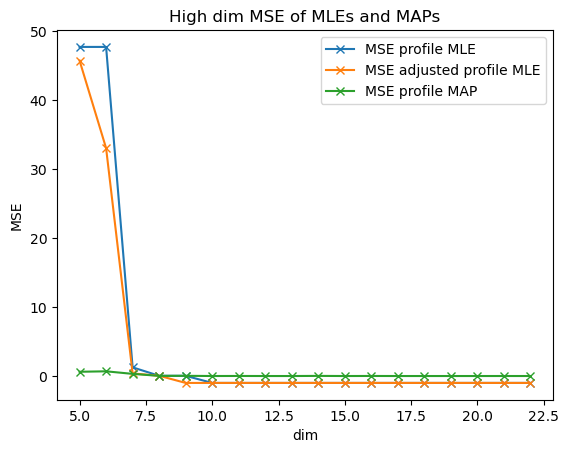

In [11]:
# Plot profile MAP(grid search) vs nu 

# Plotting
plt.plot(df['dim'], df['MSE profile MLE'], label='MSE profile MLE', marker="x")
plt.plot(df['dim'], df['MSE adj profile MLE'], label='MSE adjusted profile MLE', marker="x")
plt.plot(df['dim'], df['MSE profile joint MAP'], label='MSE profile MAP', marker="x")
#plt.plot(df['dim'], df['MSE Jeffrey post MAP'], label='MSE Jeffrey MAP', marker="x")
# Adding labels and legend
plt.xlabel('dim')
plt.ylabel('MSE')
plt.title('High dim MSE of MLEs and MAPs') 
plt.legend()
# Showing the plot
plt.show()

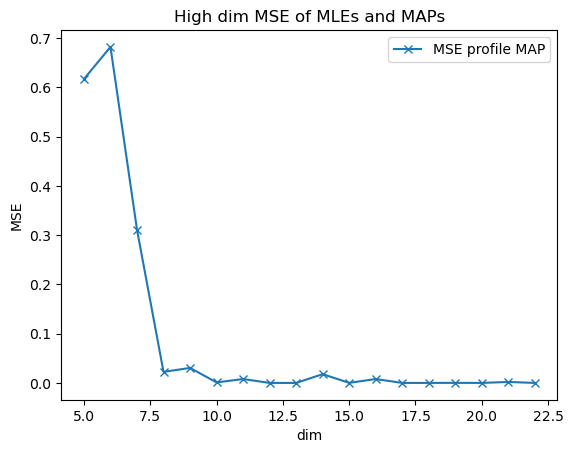

In [12]:
# Plot profile MAP(grid search) vs nu 

# Plotting
#plt.plot(df['dim'], df['MSE profile MLE'], label='MSE profile MLE', marker="x")
#plt.plot(df['dim'], df['MSE adj profile MLE'], label='MSE adjusted profile MLE', marker="x")
plt.plot(df['dim'], df['MSE profile joint MAP'], label='MSE profile MAP', marker="x")
#plt.plot(df['dim'], df['MSE Jeffrey post MAP'], label='MSE Jeffrey MAP', marker="x")
# Adding labels and legend
plt.xlabel('dim')
plt.ylabel('MSE')
plt.title('High dim MSE of MLEs and MAPs') 
plt.legend()
# Showing the plot
plt.show()